Add noise
Nguyen Viet Hoang 
Các noise model tác động lên chất lượng ảnh


In [127]:
from importlib.resources import path
from pathlib import Path 
import cv2
import numpy as np
import abc
from numpy.random import Generator
import matplotlib.pyplot as plt

class Noise(metaclass = abc.ABCMeta):
    def __init__(self, filepath: Path):
        self.filepath = filepath
        
    def get_matrix_image(self):
        return cv2.imread(str(self.filepath), cv2.IMREAD_GRAYSCALE)
    
    @abc.abstractmethod
    def noise(self)->np.array:
        pass
    
    def add_noise(self) ->np.array:
        noise_gen = self.noise().astype('uint8')
        origin_image = self.get_matrix_image()
        noisy_image = cv2.add(origin_image,noise_gen)
        print(origin_image.shape)
        cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        return noisy_image
       
class GaussianNoise(Noise):
    def __init__(self, filepath, mean = 0, var = 0.1):
        super().__init__(filepath=filepath)
        self.mean = mean
        self.var = var
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col = image.shape
        sigma = self.var**0.5
        gauss = np.random.normal(self.mean,sigma,image.size)
        gauss = gauss.reshape(row, col).astype('uint8')
        return gauss
  
class RayleighNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath=filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape
        rayleigh = np.random.rayleigh(self.scale, (row, col, ch))
        return rayleigh
    
class ExponentialNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath = filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape        
        exponent = Generator.exponential(self.scale, (row, col, ch))
        return exponent
    
class SaltAndPeperNoise(Noise):
    def __init__(self,
                 filepath: Path,
                 Ps = 0.5,
                 P = 0.004):
        super().__init__(filepath)
        self.Ps = Ps
        self.P = P
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
    
        out = np.copy(image)
        
        # Salt mode
        num_salt = np.ceil(self.P * image.size * self.Ps)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        
        # print(np.asarray(coords).shape)
        
        out[tuple(coords)] = 1
        
        
        # Pepper mode
        num_pepper = np.ceil(self.P* image.size * (self.P - self.Ps))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        
        out[tuple(coords)] = 0
        return np.asarray(out)
     
class UniformNoise(Noise):
    def __init__(self,
                 filepath:Path,
                 a = 0.0, 
                 b = 2.0):
        super().__init__(filepath=filepath)
        self.a = a
        self.b = b
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        uniform_gen = np.random.default_rng().uniform(self.a, self.b, image.shape)
        return np.asarray(uniform_gen)
    


In [122]:
import cv2
from config import Flag
import matplotlib.pyplot as plt

def metric(gt, ri):
    SE = (gt - ri)**2
    MSE = SE.mean()
    PSNR = 10*np.log10(255*255/MSE)
    return {"MSE": MSE,"PSNR":PSNR}

## Gaussian noise

{'MSE': 34.48921364118202, 'PSNR': 32.753970683616004}


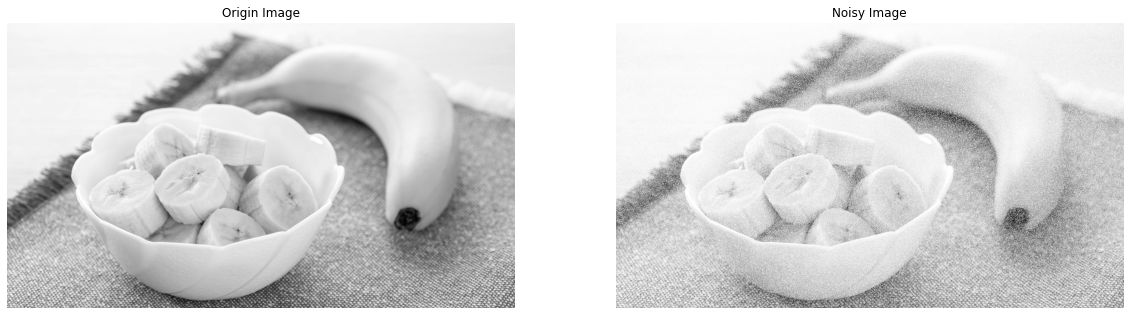

In [36]:
prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)

gauss_noise = GaussianNoise(str(file_name), mean = 0, var = 3.5)
image_gauss_noise = gauss_noise.add_noise()
# print(image_gauss_noise.shape)
eval_img = metric(image, image_gauss_noise)
print(eval_img)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_gauss_noise, cmap='gray')

## Sault and Pepper Noise

256
256
{'MSE': 0.264923095703125, 'PSNR': 53.89960539606567}


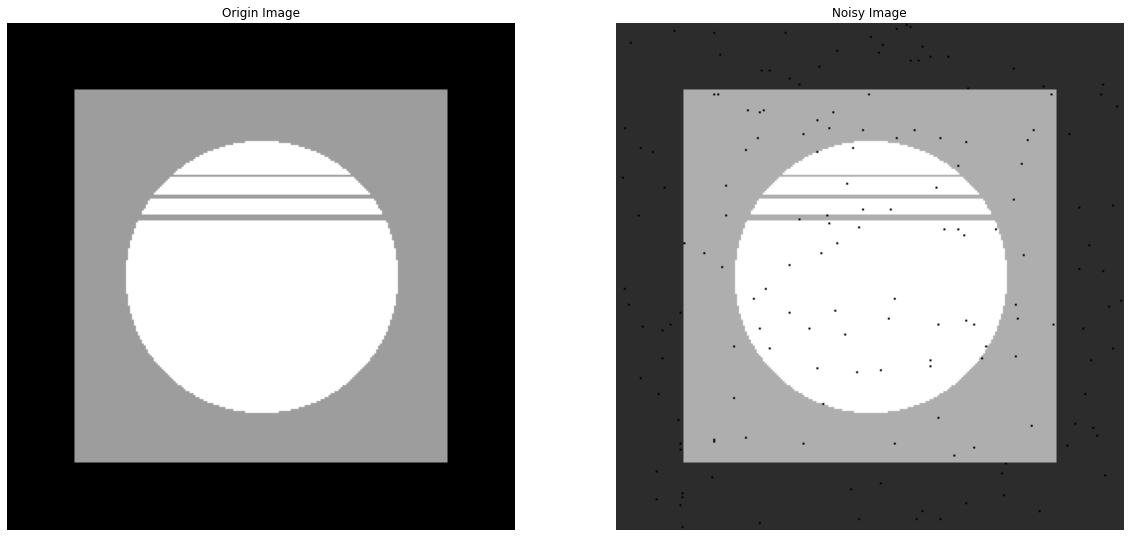

In [94]:
# from add_noise import SaltAndPeperNoise
file_name = prefix / 'pattern2.png'
image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)

saltAndPeperNoise = SaltAndPeperNoise(str(file_name), Ps=0.04, P=0.05)
image_snp_noise = saltAndPeperNoise.noise()

metric_snp = metric(image, image_snp_noise)
print(metric_snp)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_snp_noise, cmap='gray')

## Uniform Noise

(256, 256)
{'MSE': 102.48020935058594, 'PSNR': 28.024403569365948}


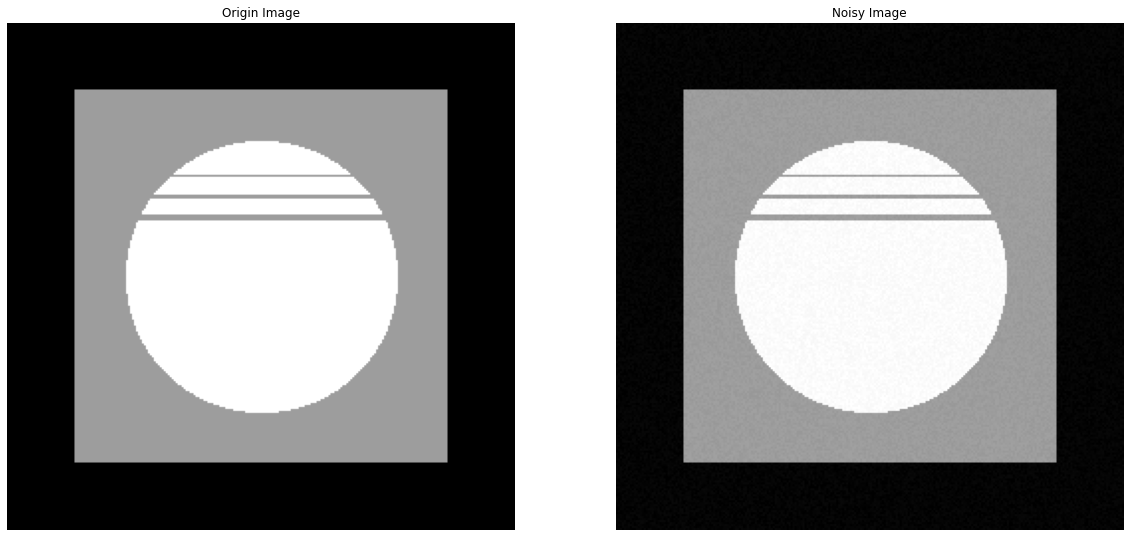

In [139]:
uni_noise = UniformNoise(filepath=file_name, a=4, b=10)
image_uni_noise = uni_noise.add_noise()


metric_snp = metric(image, image_uni_noise)
print(metric_snp)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_uni_noise, cmap='gray')



Text(0.5, 1.0, 'degraded/blurred image')

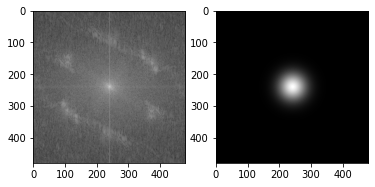

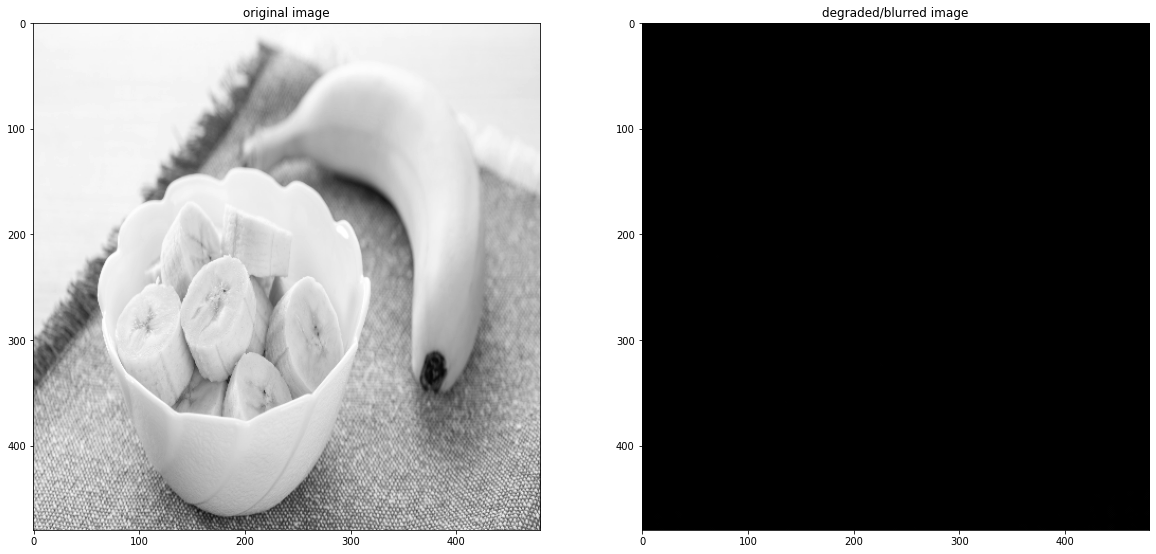

In [142]:
import cv2
from config import Flag
import numpy as np
import matplotlib.pyplot as plt
# from numpy.fft import fft, ifft, fftshift
from scipy.fftpack import fftn, ifftn, fftshift
import math
def degradation_function(M, N, k):
    arx = np.arange(0, M)
    ary = np.arange(0, N)
    u, v = np.meshgrid(arx, ary)
    de_fnc = np.exp(-k*((u-M/2)**2+(v-N/2)**2)**(5/6))
    return de_fnc

prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
im = cv2.imread(str(file_name),0)
f = cv2.imread(str(file_name),0)
f = cv2.resize(f, (480, 480))


# computing the number of padding on one side

# computing the Fourier transforms
F = fftn(f)
H = degradation_function(f.shape[0], f.shape[1],0.0025)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(np.log(np.abs(H)+1), cmap="gray")
# plt.imshow(H, cmap="gray")

# convolution
G = np.multiply(F,H)

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
# g =fftshift(ifftn(G).real)
g =(ifftn(G).real)
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")